# Structural Analysis

- The closest random graph model similar to your social network. Compare models from lectures, such as ER, BA, WS. Check real-world network properties on chosen random graph models and your network, compare the results.
- Degree/Closeness/Betweenness/Katz/Eigenvector centralities, top nodes description.
- Page-Rank/HITS in a case of directed network, top nodes description.
- Correlation comparison of centralities.
- Assortative mixing by node attributes and node degree.
- Node structural equivalence/similarity.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.stats import ks_2samp

sns.set_theme()

In [2]:
uG = nx.read_gexf("undirected_graph.gexf")
G = nx.read_gexf("directed_graph.gexf")

## The closest random graph model

In [3]:
degrees = np.array(uG.degree)[:, 1].astype(int)

In [4]:
er = nx.erdos_renyi_graph(len(uG), len(uG.edges) * 2 / (len(uG) * (len(uG) - 1)), seed=42)
ba = nx.barabasi_albert_graph(len(uG), int(len(uG.edges) / len(uG)), seed=42)
ws = nx.watts_strogatz_graph(len(uG), int(np.median(degrees)), 0.4, seed=42)

In [5]:
df = []
for model in [uG, er, ba, ws]:
    gcc = model.subgraph(max(nx.connected_components(model), key=len)).copy()
    df.append(
        [
            len(gcc),
            len(model.edges),
            nx.radius(gcc),
            nx.diameter(gcc),
            nx.algorithms.cluster.transitivity(model),
            nx.average_clustering(model),
            nx.average_shortest_path_length(gcc),
            1 - ks_2samp(degrees, np.array(model.degree)[:, 1].astype(int)).statistic,
        ]
    )

pd.DataFrame(
    df,
    columns=[
        "GCC size",
        "Edges",
        "Radius",
        "Diameter",
        "Global CC",
        "Average local CC",
        "Average path length",
        "KS test",
    ],
    index=["Current", "ER", "BA", "WS"],
)

,GCC size,Edges,Radius,Diameter,Global CC,Average local CC,Average path length,KS test
Current,374,1099,4,7,0.045161,0.130321,2.958653,1.000000
ER,372,1093,4,6,0.011416,0.010854,3.537750,0.647059
BA,374,744,4,6,0.023757,0.066421,3.557555,0.796791
WS,374,748,6,9,0.110482,0.126853,4.950467,0.711230


Граф не похож на модель small world - он имеет низкий коэффициент кластеризации

Лучше всего граф описывает модель Барабаши-Альберт (см. диаметр и кратчайший путь). Основная идея заключается в том, что чем больше человек ставит реакций (получает реакций), тем больше он будет ставить реакций в будущем (получать реакций, становясь популярным). Это модель для scale-free networks, что подходит под описание нашей сети

## Centralities

In [6]:
def katz_centrality(G, n, beta):
    A = np.array(nx.to_numpy_matrix(G))
    assert beta < 1 / max(np.linalg.eigvals(A))
    # return beta * np.linalg.inv(np.eye(A.shape[0]) - beta * A) @ A @ np.ones(A.shape[0])
    k = []
    for i in range(1, n + 1):
        k.append(beta ** i * np.sum(np.linalg.matrix_power(A, i), axis=1))
    return np.sum(k, axis=0)

In [7]:
def eigenvector_centrality(A):
    w, v = np.linalg.eigh(A)
    eigvec = v[:, w.argmax()]
    return np.abs(eigvec)

In [8]:
def centralities(G):
    return {
        "degree": np.array(list(nx.degree_centrality(G).values())),
        "closeness": np.array(list(nx.closeness_centrality(G).values())),
        "betweenness": np.array(list(nx.betweenness_centrality(G).values())),
        "katz": np.array(list(katz_centrality(G, 20, 0.06))),
        "eigenvector": np.array(list(eigenvector_centrality(nx.to_numpy_array(G)))),
    }

In [9]:
c = centralities(uG)

In [10]:
_stations = pd.DataFrame(
    {
        "company": list(nx.get_node_attributes(uG, "company").values()),
        "name": list(nx.get_node_attributes(uG, "name").values()),
    }
)
degree_df = _stations.copy()
degree_df["centrality"] = list(nx.degree_centrality(uG).values())
closeness_df = _stations.copy()
closeness_df["centrality"] = list(nx.closeness_centrality(uG).values())
betweenness_df = _stations.copy()
betweenness_df["centrality"] = list(nx.betweenness_centrality(uG).values())
katz_df = _stations.copy()
katz_df["centrality"] = katz_centrality(uG, 20, 0.06)
eigenvector_df = _stations.copy()
eigenvector_df["centrality"] = eigenvector_centrality(nx.to_numpy_array(uG))
res = {
    "degree": degree_df.sort_values("centrality", ascending=False).head(5),
    "closeness": closeness_df.sort_values("centrality", ascending=False).head(5),
    "betweenness": betweenness_df.sort_values("centrality", ascending=False).head(5),
    "katz": katz_df.sort_values("centrality", ascending=False).head(5),
    "eigenvector": eigenvector_df.sort_values("centrality", ascending=False).head(5),
}

In [11]:
layout = nx.kamada_kawai_layout(uG)

Degree centrality


,company,name,centrality
189,x5,sergey zakharov,0.436997
112,undefined,Mikhail Chesnokov,0.147453
85,undefined,Valentin Malykh,0.117962
170,undefined,Igor Kotenkov,0.093834
78,revolut,Pavel Nesterov,0.088472


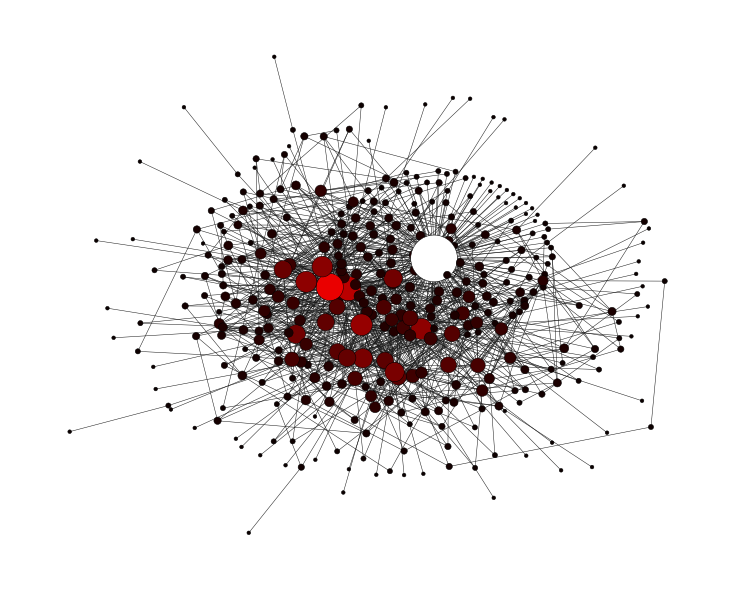

Closeness centrality


,company,name,centrality
189,x5,sergey zakharov,0.587402
112,undefined,Mikhail Chesnokov,0.472152
170,undefined,Igor Kotenkov,0.465668
85,undefined,Valentin Malykh,0.455990
78,revolut,Pavel Nesterov,0.455433


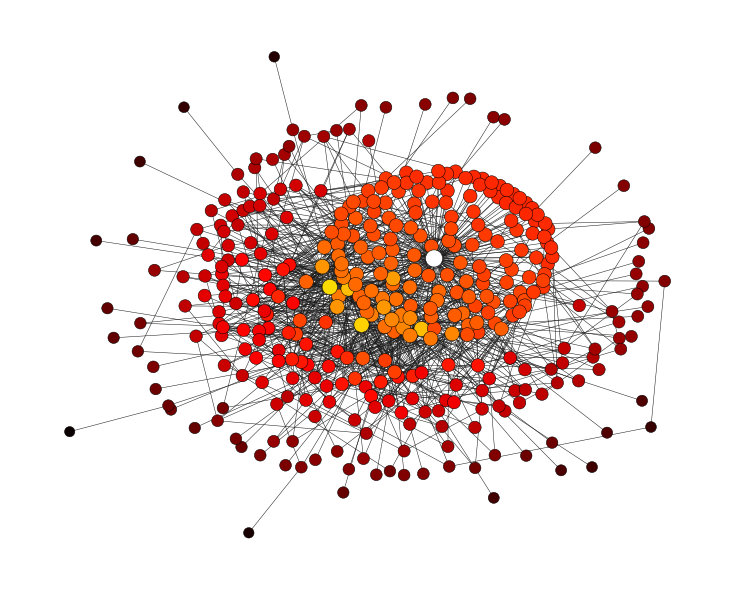

Betweenness centrality


,company,name,centrality
189,x5,sergey zakharov,0.533765
112,undefined,Mikhail Chesnokov,0.090896
85,undefined,Valentin Malykh,0.060347
170,undefined,Igor Kotenkov,0.056021
262,3opinion,Alexander Gromov,0.051491


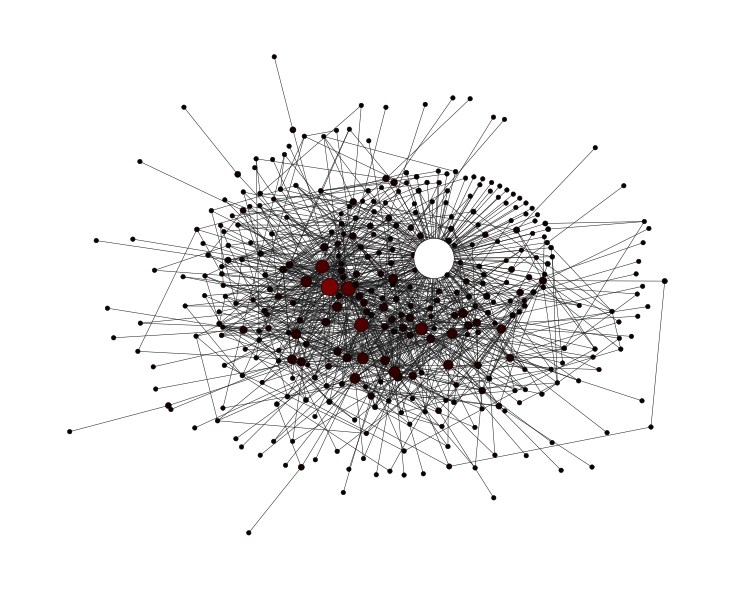

Katz centrality


,company,name,centrality
189,x5,sergey zakharov,113.331203
112,undefined,Mikhail Chesnokov,46.806436
85,undefined,Valentin Malykh,38.756254
170,undefined,Igor Kotenkov,34.161666
78,revolut,Pavel Nesterov,33.600934


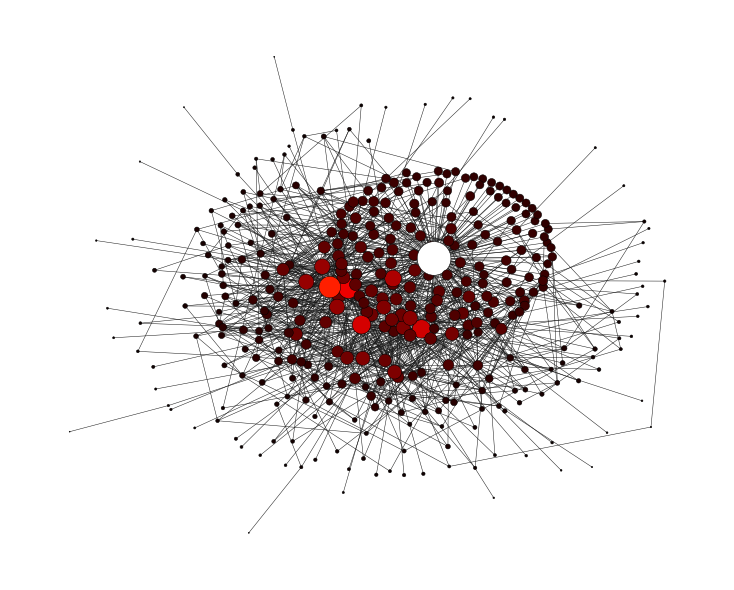

Eigenvector centrality


,company,name,centrality
189,x5,sergey zakharov,0.531541
112,undefined,Mikhail Chesnokov,0.220919
85,undefined,Valentin Malykh,0.182774
170,undefined,Igor Kotenkov,0.160551
78,revolut,Pavel Nesterov,0.159572


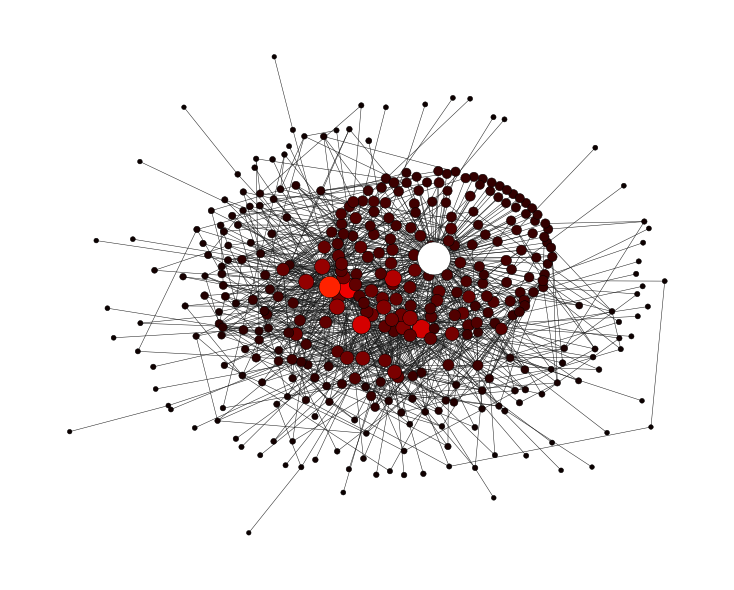

In [12]:
cases = [
    ["degree", 5000, 0, "Degree centrality"],
    ["closeness", 500, 0, "Closeness centrality"],
    ["betweenness", 3000, 20, "Betweenness centrality"],
    ["katz", 10, 0, "Katz centrality"],
    ["eigenvector", 2000, 20, "Eigenvector centrality"],
]
for c_key, scale, bias, title in cases:
    print(title)
    display(res[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(
        uG,
        layout,
        width=0.5,
        linewidths=0.5,
        edgecolors="black",
        cmap=plt.cm.hot,
        node_size=c[c_key] * scale + bias,
        node_color=c[c_key],
    )
    plt.show()

По всем центральностям наибольшее значение имеет Sergey Zakharov - он связывает большое количество нод, поскольку ставит очень много реакций. Топ по центральнстям практически не изменяется (Mikhail Chesnokov, Valentin Malykh, Igor Kotenkov - ставят большое количество реакций, Pavel Nesterov - получил большое количество реакций).

## Page-Rank/HITS

In [13]:
pagerank = nx.pagerank(G)

In [14]:
pagerank = pd.DataFrame([pagerank]).T.reset_index()
pagerank.columns = ["id", "pagerank"]

In [15]:
_stations = pd.DataFrame(
    {
        "company": list(nx.get_node_attributes(G, "company").values()),
        "name": list(nx.get_node_attributes(G, "name").values()),
        "id": G.nodes,
    }
)
pagerank_df = _stations.merge(pagerank, on="id")
pagerank_df.sort_values("pagerank", ascending=False).head(10)[["company", "name", "pagerank"]]

,company,name,pagerank
84,2a2i,Дмитрий Бабаев,0.009445
44,undefined,Vladimir Tokarev,0.009355
82,x5,Artur Kuzin,0.008102
100,undefined,Taras Baranyuk,0.007848
299,mail,Vladimircape,0.007736
161,severstal,Ksenia Kingsep,0.007643
109,careem,Olesya Borzdyko,0.007446
225,undefined,Alexander Donchuk,0.007059
300,sberbank,Sergei Alekseev,0.006976
244,rian,Artyom Stepanov,0.006799


Полученные ноды имеют много полученных реакций и сами активно поставляют реакции

In [16]:
hub, auth = nx.hits(G)

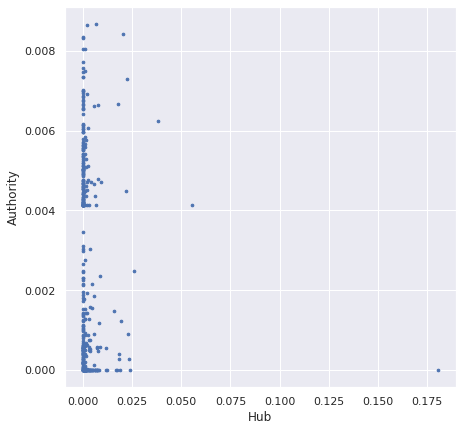

In [17]:
plt.figure(figsize=(7, 7))
plt.scatter(hub.values(), auth.values(), s=7)
plt.xlabel("Hub")
plt.ylabel("Authority")
plt.show()

В графе мало людей с большим количеством полученных реакций, но много людей, ставящих реакции

In [18]:
def hits_visualization(G, hub, auth, top):
    h_top = {k: v for k, v in sorted(hub.items(), key=lambda x: -x[1])[:top]}
    a_top = {k: v for k, v in sorted(auth.items(), key=lambda x: -x[1])[:top]}
    sub_nodes = sorted(set(h_top.keys()) | set(a_top.keys()))
    subG = G.subgraph(sub_nodes).copy()
    return {
        "h_top": np.array(list(h_top.keys())),
        "a_top": np.array(list(a_top.keys())),
        "subG": subG,
        "h_vals": np.array([hub[node] for node in subG.nodes]),
        "a_vals": np.array([auth[node] for node in subG.nodes]),
        "pos": {
            node: [
                0 if node in h_top else 1,
                list(h_top.keys()).index(node) if node in h_top else list(a_top.keys()).index(node),
            ]
            for node in subG.nodes
        },
    }

In [19]:
vi = hits_visualization(G, hub, auth, 7)
h_top, a_top = vi["h_top"], vi["a_top"]
h_vals, a_vals = vi["h_vals"], vi["a_vals"]
subG, pos = vi["subG"], vi["pos"]

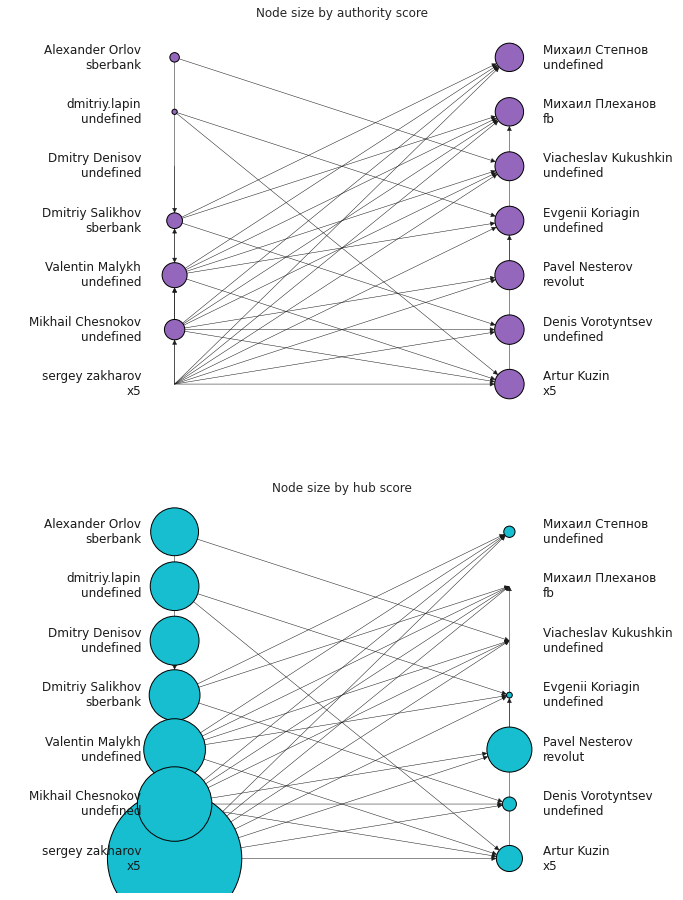

In [21]:
plt.figure(figsize=(12, 16))

h_labels = {i: G.nodes[i]["name"] + "\n" + G.nodes[i]["company"] for i in h_top}
a_labels = {i: G.nodes[i]["name"] + "\n" + G.nodes[i]["company"] for i in a_top}
a_pos = {node: (pos[node][0] + 0.1, pos[node][1]) for node in pos}
h_pos = {node: (pos[node][0] - 0.1, pos[node][1]) for node in pos}

cases = [[1, "tab:purple", a_vals, "Node size by authority score"], [2, "tab:cyan", h_vals, "Node size by hub score"]]
for i, color, vals, t in cases:
    plt.subplot(2, 1, i)
    plt.gca().axis("off")
    nx.draw_networkx(
        subG, pos, width=0.5, with_labels=False, edgecolors="black", node_size=vals * 1e5, node_color=color
    )
    nx.draw_networkx_labels(subG, pos=a_pos, labels=a_labels, horizontalalignment="left")
    nx.draw_networkx_labels(subG, pos=h_pos, labels=h_labels, horizontalalignment="right")

    plt.xlim(-0.5, 1.5)
    plt.title(t)

## Correlation comparison of centralities

In [22]:
res_df = pd.DataFrame([v["centrality"].values for k, v in res.items()]).T
res_df.columns = res.keys()

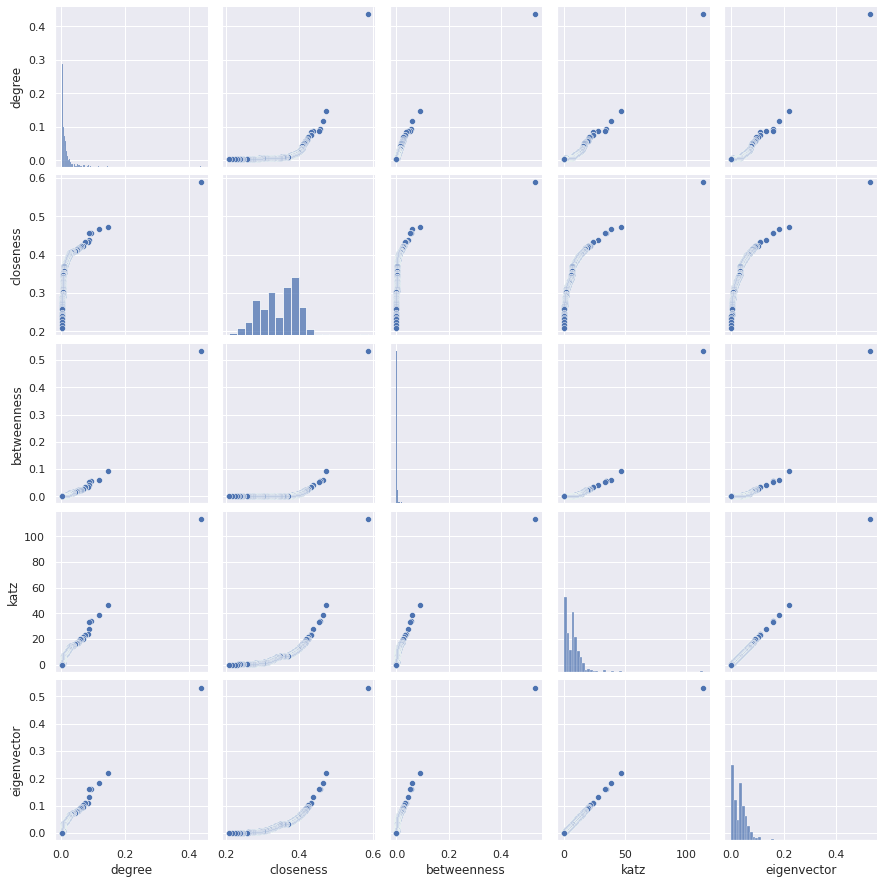

In [23]:
sns.pairplot(res_df);

In [24]:
corr = res_df.corr()
corr

,degree,closeness,betweenness,katz,eigenvector
degree,1.000000,0.625451,0.932634,0.962970,0.959192
closeness,0.625451,1.000000,0.407706,0.798432,0.805684
betweenness,0.932634,0.407706,1.000000,0.841361,0.835603
katz,0.962970,0.798432,0.841361,1.000000,0.999813
eigenvector,0.959192,0.805684,0.835603,0.999813,1.000000


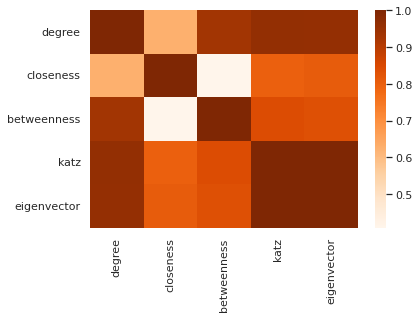

In [25]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="Oranges");

Сильнее всего похожи katz и eigenvector центральности (описывают важность ноды). Больше всего различаются betweenness и closeness центральности (ноды, через которые проходит наибольшее кол-во кратчайших путей, не всегда совпадают с нодами с минимальным расстоянием до других нод)

## Assortative mixing by node attributes and node degree

### Assortative mixing by node attributes

In [39]:
def conferences_mixing_matrix(G, mapping):
    m = G.number_of_edges()
    E = np.zeros((len(mapping), len(mapping)))
    for e in G.edges:
        if G.nodes[e[0]]["company"] in mapping:
            e0 = mapping[G.nodes[e[0]]["company"]]
        else:
            e0 = mapping["undefined"]
        if G.nodes[e[1]]["company"] in mapping:
            e1 = mapping[G.nodes[e[1]]["company"]]
        else:
            e1 = mapping["undefined"]
        E[e0, e1] += 1
        E[e1, e0] += 1
    return E / m / 2

In [44]:
def company_mixing_matrix(G, mapping):
    m = G.number_of_edges()
    E = np.zeros((len(mapping), len(mapping)))
    for e in G.edges:
        if G.nodes[e[0]]["company"] in mapping and G.nodes[e[1]]["company"] in mapping:
            e0 = mapping[G.nodes[e[0]]["company"]]
            e1 = mapping[G.nodes[e[1]]["company"]]
            E[e0, e1] += 1
            E[e1, e0] += 1
    return E / m / 2

In [45]:
top_companies = [
    "sberbank",
    "raiffeisen",
    "ozon",
    "alfabank",
    "rt",
    "2a2i",
    "samsung",
    "tinkoff",
    "ostrovok",
    "x5",
    "beeline",
    "huawei",
    "open",
    "sportmaster",
    "sbdagroup",
    "avito",
]

In [46]:
mapping = {val: i for i, val in enumerate(top_companies)}
mixing = company_mixing_matrix(uG, mapping)

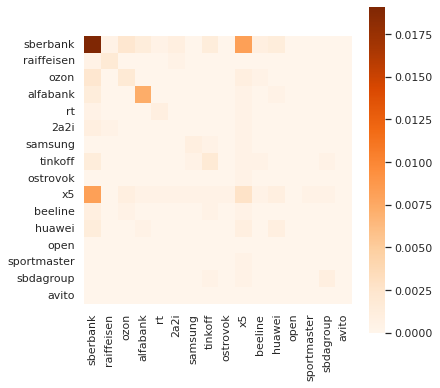

In [47]:
fig = plt.figure(figsize=(6, 6))
hmap = sns.heatmap(
    mixing, cbar=True, square=True, cmap="Oranges", xticklabels=mapping.keys(), yticklabels=mapping.keys()
);

In [48]:
def assortativity_coef(mixing):
    return (np.trace(mixing) - np.sum(mixing @ mixing)) / (1 - np.sum(mixing @ mixing))

In [49]:
print(f"Assortativity coefficient: {assortativity_coef(mixing):.4f}")

Assortativity coefficient: 0.0365


Сеть не является ассортативной, однако можно отметить, что некоторые компании (Сбер и Альфа Банк) ставят себе большое количествоо реакций. Пара x5 и Сбер также выделается, поскольку Sergey Zakharov из x5 ставит большое количество реакций, а наибольшее количество вакансий в графе из Сбера

### Assortative mixing by in node degree

In [52]:
def in_degree_mixing_matrix(G, mapping):
    m = G.number_of_edges()
    E = np.zeros((len(mapping), len(mapping)))
    for e in G.edges:
        e0 = mapping[G.in_degree[e[0]]]
        e1 = mapping[G.in_degree[e[1]]]
        E[e0, e1] += 1
        E[e1, e0] += 1
    return E / m / 2

In [56]:
in_degrees = sorted(np.unique(np.array(G.in_degree)[:, 1].astype(int)))
mapping = {val: i for i, val in enumerate(in_degrees)}
mixing = in_degree_mixing_matrix(G, mapping)

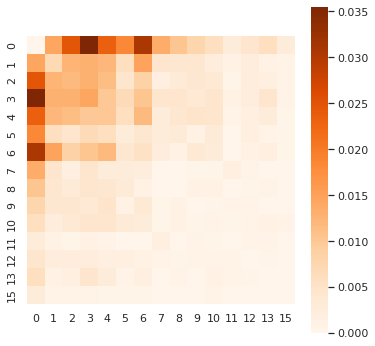

In [57]:
fig = plt.figure(figsize=(6, 6))
hmap = sns.heatmap(
    mixing, cbar=True, square=True, cmap="Oranges", xticklabels=mapping.keys(), yticklabels=mapping.keys()
);

In [58]:
print(f"Assortativity coefficient: {assortativity_coef(mixing):.4f}")

Assortativity coefficient: -0.0630


Сеть не является ассортативной, однако есть тенденция в тому, что ноды с небольшой входящей степенью ставят реакции нодам с большой степенью

### Assortative mixing by out node degree

In [59]:
def out_degree_mixing_matrix(G, mapping):
    m = G.number_of_edges()
    E = np.zeros((len(mapping), len(mapping)))
    for e in G.edges:
        e0 = mapping[G.out_degree[e[0]]]
        e1 = mapping[G.out_degree[e[1]]]
        E[e0, e1] += 1
        E[e1, e0] += 1
    return E / m / 2

In [60]:
out_degrees = sorted(np.unique(np.array(G.out_degree)[:, 1].astype(int)))
mapping = {val: i for i, val in enumerate(out_degrees)}
mixing = out_degree_mixing_matrix(G, mapping)

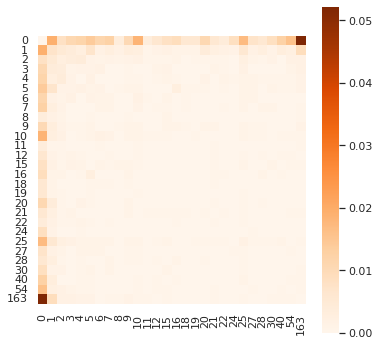

In [61]:
fig = plt.figure(figsize=(6, 6))
hmap = sns.heatmap(
    mixing, cbar=True, square=True, cmap="Oranges", xticklabels=mapping.keys(), yticklabels=mapping.keys()
);

In [62]:
print(f"Assortativity coefficient: {assortativity_coef(mixing):.4f}")

Assortativity coefficient: -0.1210


Сеть является дисассортативной, то есть присутствует тенденция в тому, что ноды с большой исходящей степенью ставят реакции нодам с небольшой степенью (в основном засчет Sergey Zakharov)

## Node structural equivalence/similarity

In [64]:
def sim_values(A, i, j):
    pval = np.corrcoef(A[i], A[j])[0, 1]
    jval = (A[i] * A[j]).sum() / ((A[i] + A[j]) != 0).sum()
    cval = A[i].T @ A[j] / np.linalg.norm(A[i]) / np.linalg.norm(A[j])
    return pval, jval, cval

In [65]:
def cm_order(G):
    return reverse_cuthill_mckee(nx.adjacency_matrix(G))

In [72]:
order = cm_order(uG)

In [73]:
A = nx.to_numpy_array(uG)[np.ix_(order, order)]
cos_sim = np.zeros(A.shape)
pearson_sim = np.zeros(A.shape)
jaccard_sim = np.zeros(A.shape)
for i in range(len(uG)):
    for j in range(i, (len(uG))):
        pval, jval, cval = sim_values(A, i, j)
        pearson_sim[i, j] = pval
        pearson_sim[j, i] = pval
        jaccard_sim[i, j] = jval
        jaccard_sim[j, i] = jval
        cos_sim[i, j] = cval
        cos_sim[j, i] = cval

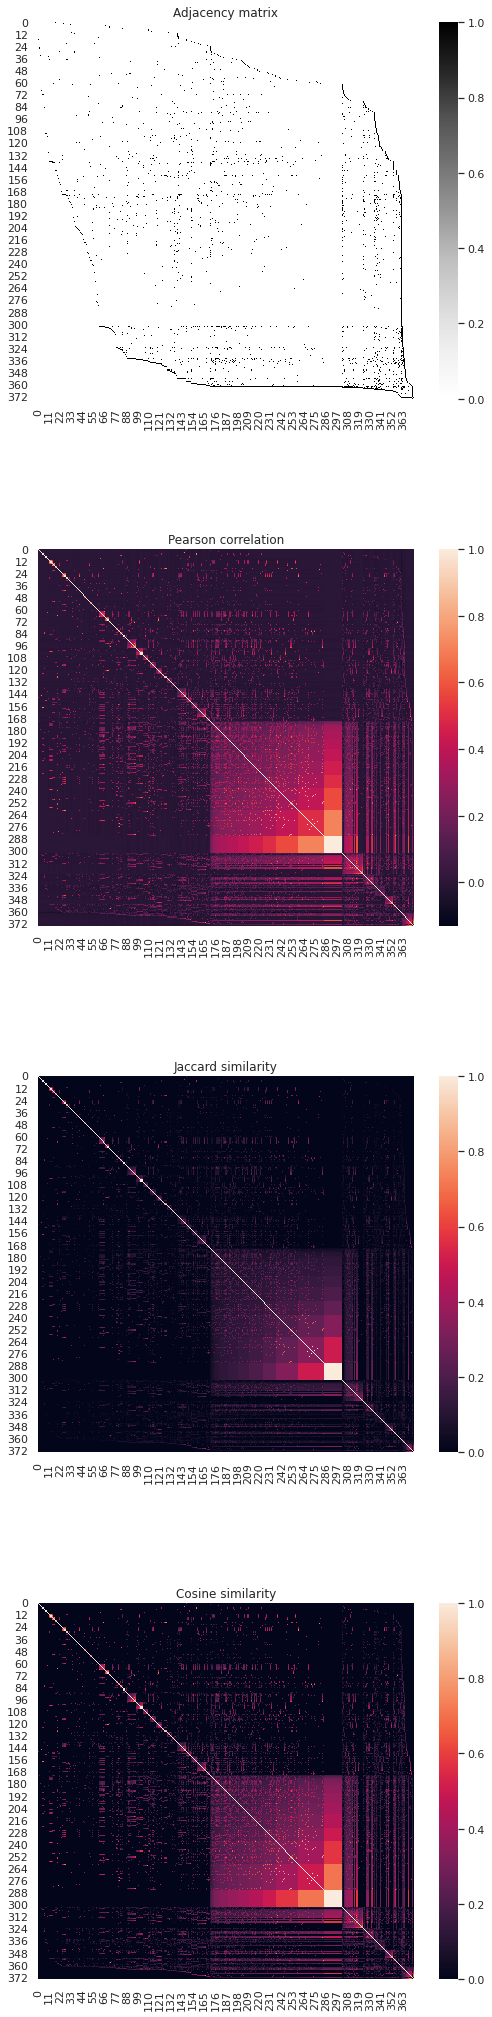

In [74]:
fig = plt.figure(figsize=(9, 9 * 4))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
cases = [
    [1, A, plt.cm.Greys, "Adjacency matrix"],
    [2, pearson_sim, None, "Pearson correlation"],
    [3, jaccard_sim, None, "Jaccard similarity"],
    [4, cos_sim, None, "Cosine similarity"],
]
for i, matrix, cmap, t in cases:
    plt.subplot(4, 1, i)
    hmap = sns.heatmap(matrix, cmap=cmap, square=True)
    plt.title(t)

В графе можно выделить одну большую группу схожих нод, однако оставшиеся ноды практически не схожи между собой, сеть не имеет ярко выраженных кластеров